In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    print("using cpu...")

using cuda: NVIDIA GeForce MX150


In [5]:
torch.tensor([1.2, 3]).dtype

torch.float32

In [6]:
class MnistDataset(Dataset):

    def __init__(self, train=True) -> None:
        print("Loading mnist dataset, please wait about 10 seconds...")

        x_train, x_test, t_train, t_test = datasets.load_mnist()
        if train:
            self.x = torch.tensor(x_train)
            self.t = torch.tensor(t_train)
        else:
            self.x = torch.tensor(x_test)
            self.t = torch.tensor(t_test)

        self.x = self.x.float()
        self.t = self.t.float()

        print("Mnist dataset loaded.")

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.t[index]

    def plot_image(self, index):
        image = self.x[index]
        label = self.t[index]

        if image.is_cuda:
            image = image.cpu()
        if label.is_cuda:
            label = label.cpu()


        ax = plt.figure().add_subplot()
        ax.axis('off')
        ax.text(1, 5, int(torch.argmax(label)), color='k')
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.Blues)

In [7]:
dataset = MnistDataset()

Loading mnist dataset, please wait about 10 seconds...
Mnist dataset loaded.


In [8]:
dataset.x[0].is_cuda, dataset.t[0].is_cuda

(True, True)

In [9]:
dataset.x[0].dtype, dataset.t[0].dtype

(torch.float32, torch.float32)

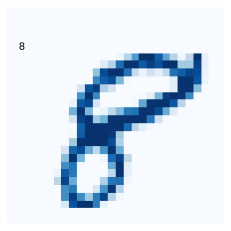

In [10]:
dataset.plot_image(1)

In [11]:
class Classifier(nn.Module):

    def __init__(self, input, hidden, output) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input, hidden),
            nn.Sigmoid(),
            # nn.Dropout(),

            # nn.LayerNorm(hidden),


            nn.Linear(hidden, output),
            nn.Sigmoid(),
        )

        # self.loss_function = nn.BCEWithLogitsLoss()
        # self.loss_function = nn.BCELoss()
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        return self.model(x)


In [12]:

batch_size = 1000

net = Classifier(784, 100, 10)

epoch = 200

loss_list = []
acc_list = []

bar = tqdm(range(epoch))

generator = None
if torch.cuda.is_available():
    generator=torch.Generator(device='cuda')

for e in bar:

    total = 0
    right = 0

    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
        # pin_memory=True
    )

    for x, t in dataloader:
        y = net.forward(x)

        loss = net.loss_function(y, t)

        net.optimizer.zero_grad()

        loss.backward()

        net.optimizer.step()

        total += x.shape[0]
        right += torch.sum(
            torch.argmax(y, axis=1) == torch.argmax(t, axis=1)
        )

        acc = right / total * 100

        loss_list.append(loss.item())
        acc_list.append(acc.cpu())
        bar.set_postfix(dict(acc=f"{int(acc)}%", loss=f"{loss.item():0.2}",))


100%|██████████| 200/200 [03:45<00:00,  1.13s/it, acc=99%, loss=0.00067]


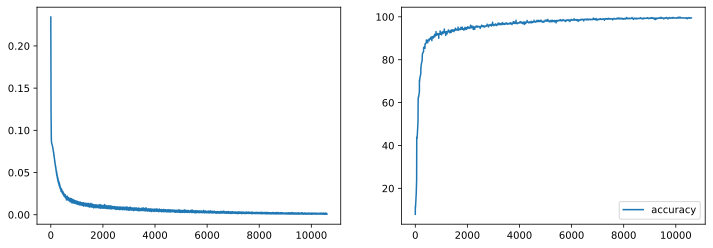

In [13]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
axes.legend()
plt.show()

In [14]:
testset = MnistDataset(train=False)

Loading mnist dataset, please wait about 10 seconds...
Mnist dataset loaded.


In [15]:
right = 0
total = 0

dataloader = DataLoader(
    dataset=testset,
    batch_size=batch_size,
)

bar = tqdm(dataloader)

for x, t in bar:
    y = net.forward(x)

    total += x.shape[0]
    right += torch.sum(torch.argmax(y, axis=1) == torch.argmax(t, axis=1))

    acc = right / total * 100

    bar.set_postfix(dict(acc=f"{acc.float():0.3}%",))


100%|██████████| 18/18 [00:00<00:00, 38.90it/s, acc=99.0%]
